In [47]:
import scGAM as scGAM
import gseapy

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import numpy as np
import scanpy.external as sce

In [49]:
from pygam import LinearGAM, s
import numpy as np
import pandas as pd
import time
from collections import OrderedDict
from joblib import delayed, Parallel
from sklearn.preprocessing import StandardScaler
import scanpy as sc
import seaborn as sns

In [50]:
import pygam

In [51]:
print(pygam.__version__)

0.8.0


In [52]:
sc.settings.verbosity = 3  
# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, facecolor='white', frameon=True, figsize=(5, 5))

-----
anndata     0.9.1
scanpy      1.9.3
-----
PIL                         9.1.1
anyio                       NA
asciitree                   NA
attr                        21.2.0
babel                       2.9.1
backcall                    0.2.0
brotli                      NA
certifi                     2022.12.07
cffi                        1.15.0
charset_normalizer          2.0.7
cloudpickle                 2.2.0
colorama                    0.4.6
cycler                      0.10.0
cython_runtime              NA
cytoolz                     0.12.1
dask                        2023.5.1
dateutil                    2.8.2
debugpy                     1.5.0
decorator                   5.1.1
defusedxml                  0.7.1
dill                        0.3.6
entrypoints                 0.3
fasteners                   0.18
fastjsonschema              NA
google                      NA
gseapy                      1.0.4
h5py                        3.7.0
idna                        3.3
igraph     

In [55]:
# samples_dict = {"Immature": "A0021_043", "0hr": "A0008_041", "1hr": "A0021_044", "4hr": "A0008_045", "4hr_replicate": "A0021_042", "6hr": "A0021_045", "8hr": "A0008_044", "8hr_replicate": "A0021_038", "11hr": "A0008_046", "12hr": "A0021_046"}
samples_dict = {"Immature": "A0021_043", "0hr": "A0008_041", "1hr": "A0021_044", "4hr": "A0021_042", "6hr": "A0021_045", "8hr": "A0008_044", "11hr": "A0008_046", "12hr": "A0021_046"}

In [56]:
s_genes = list(pd.read_csv("./../../../../MouseInfection/s.genes.txt")["x"])
g2m_genes = list(pd.read_csv("./../../../../MouseInfection/g2m.genes.txt")["x"])
print(s_genes)
print(g2m_genes)

['Mcm4', 'Exo1', 'Slbp', 'Gmnn', 'Cdc45', 'Msh2', 'Mcm6', 'Rrm2', 'Pold3', 'Blm', 'Ubr7', 'Mcm5', 'Clspn', 'Hells', 'Nasp', 'Rpa2', 'Rad51ap1', 'Tyms', 'Rrm1', 'Rfc2', 'Prim1', 'Brip1', 'Usp1', 'Ung', 'Pola1', 'Mcm2', 'Fen1', 'Tipin', 'Pcna', 'Cdca7', 'Uhrf1', 'Casp8ap2', 'Cdc6', 'Dscc1', 'Wdr76', 'E2f8', 'Dtl', 'Ccne2', 'Atad2', 'Gins2', 'Chaf1b', 'Pcna-ps2']
['Nuf2', 'Psrc1', 'Ncapd2', 'Ccnb2', 'Smc4', 'Lbr', 'Tacc3', 'Cenpa', 'Kif23', 'Cdca2', 'Anp32e', 'G2e3', 'Cdca3', 'Anln', 'Cenpe', 'Gas2l3', 'Tubb4b', 'Cenpf', 'Dlgap5', 'Hjurp', 'Cks1brt', 'Gtse1', 'Bub1', 'Birc5', 'Ube2c', 'Rangap1', 'Hmmr', 'Ect2', 'Tpx2', 'Ckap5', 'Cbx5', 'Nek2', 'Ttk', 'Cdca8', 'Nusap1', 'Ctcf', 'Cdc20', 'Cks2', 'Mki67', 'Tmpo', 'Ckap2l', 'Aurkb', 'Kif2c', 'Cdk1', 'Kif20b', 'Top2a', 'Aurka', 'Ckap2', 'Hmgb2', 'Cdc25c', 'Ndc80', 'Kif11']


In [53]:
adata_ovary_combined = sc.read_h5ad("./../../pyobjs_github/adata_ovary_combined_processed_deconvoluted_newscaling.h5ad")
adata_ovary_combined.uns['log1p'] = {'base' : None}
adata_ovary_combined.shape

(121536, 2537)

In [57]:
granulosa = sc.read_h5ad("./../../pyobjs_github/granulosa1.h5ad")
granulosa.uns['log1p'] = {'base' : None}
granulosa.shape

(58038, 31053)

In [58]:
adata_ovary_combined.obs["granulosa_celltypes_reduced"] = adata_ovary_combined.obs["Level0_max_pred_celltype"]
adata_ovary_combined.obs["granulosa_celltypes_reduced"] = adata_ovary_combined.obs["granulosa_celltypes_reduced"].astype(str)
adata_ovary_combined.obs.loc[granulosa.obs_names,"granulosa_celltypes_reduced"] = granulosa.obs["granulosa_celltypes_reduced"]
adata_ovary_combined.obs["granulosa_celltypes_reduced"] = adata_ovary_combined.obs["granulosa_celltypes_reduced"].astype("category")

In [ ]:
del adata_ovary_combined

In [59]:
granulosa_mural = sc.read_h5ad("./../../pyobjs_github/granulosa_mural.h5ad")
granulosa_mural.uns['log1p']["base"] = None
granulosa_mural.shape

(54508, 31053)

In [60]:
granulosa_temp = granulosa_mural[granulosa_mural.obs["Sample"] == "Immature"]
sc.tl.rank_genes_groups(granulosa_temp, groupby="granulosa_celltypes_follicle_type", method="wilcoxon", key_added="rank_gene_groups_granulosa_celltypes_follicle_type")
sc.tl.rank_genes_groups(granulosa_temp, groupby="granulosa_celltypes_reduced", key_added="rank_gene_groups_granulosa_celltypes_reduced")

ranking genes


/home/mm2937/.local/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


    finished: added to `.uns['rank_gene_groups_granulosa_celltypes_follicle_type']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:20)
ranking genes
    finished: added to `.uns['rank_gene_groups_granulosa_celltypes_reduced']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


In [ ]:
result = granulosa_temp.uns['rank_gene_groups_granulosa_celltypes_follicle_type']
groups = result['names'].dtype.names
dge_results = pd.DataFrame(
    {group + '_' + key: result[key][group]
    for group in groups for key in ['names', "logfoldchanges", "pvals_adj"]})
marker_list = list()
for group in result['names'].dtype.names:
    markers = sc.get.rank_genes_groups_df(granulosa_temp, key='rank_gene_groups_granulosa_celltypes_follicle_type', group = group)
    markers["celltypes"] = group
    marker_list.append(markers)
df = marker_list[1]
df = df.set_index("names")
df.to_csv("./../pyobjs/Immature_rank_gene_groups_granulosa_celltypes_reduced.csv")

In [ ]:
sc.tl.dendrogram(granulosa_temp, groupby="granulosa_celltypes_reduced")
sc.settings.set_figure_params(dpi=300, dpi_save= 300, fontsize=6, facecolor='white', frameon=False, figsize=(2.0, 2.0), vector_friendly = False, transparent=True, format="pdf")
sc.pl.rank_genes_groups_matrixplot(granulosa_temp, key="rank_gene_groups_granulosa_celltypes_follicle_type", n_genes=10, cmap='RdBu_r', values_to_plot="logfoldchanges", min_logfoldchange=1.0, save="rank_gene_groups_granulosa_celltypes_follicle_type", figsize = (6,0.4))
sc.settings.set_figure_params(dpi=80, facecolor='white', frameon=True, figsize=(2, 2))

In [41]:
def plot_2_genes_spatial_prep(adata, gene1, gene2, detection_threshold = 0.5, use_raw = True):
    pairs_d = {(True, True): "Both expressed",
               (True, False): f"{gene1} not {gene2}",
               (False, True): f"{gene2} not {gene1}",
               (False, False): "Neither expressed"}
    if use_raw:
        adata.obs[f"{gene1}_{gene2}"] = [pairs_d[x] for x in zip(adata.raw.to_adata().to_df()[gene1] > detection_threshold, adata.raw.to_adata().to_df()[gene2] > detection_threshold)]
    else:
        adata.obs[f"{gene1}_{gene2}"] = [pairs_d[x] for x in zip(adata.to_df()[gene1] > detection_threshold, adata.to_df()[gene2] > detection_threshold)]
    print(f"{gene1}_{gene2}" + " added to .obs")
    return adata

In [42]:
def plot_2_gene_programs_spatial_prep(adata, gene_dict1 , gene_dict2, detection_threshold = 0.5, use_raw = True):
    pairs_d = {(True, True): "Both expressed",
               (True, False): f"{list(gene_dict1.keys())[0]} not {list(gene_dict2.keys())[0]}",
               (False, True): f"{list(gene_dict2.keys())[0]} not {list(gene_dict1.keys())[0]}",
               (False, False): "Neither expressed"}
    if use_raw:
        adata.obs[f"{list(gene_dict1.keys())[0]}_{list(gene_dict2.keys())[0]}"] = [pairs_d[x] for x in zip(adata.raw.to_adata().to_df()[list(gene_dict1.values())[0]].sum(axis = 1) > detection_threshold, adata.raw.to_adata().to_df()[list(gene_dict2.values())[0]].sum(axis = 1) > detection_threshold)]
    else:
        adata.obs[f"{list(gene_dict1.keys())[0]}_{list(gene_dict2.keys())[0]}"] = [pairs_d[x] for x in zip(adata.to_df()[list(gene_dict1.values())[0]].sum(axis = 1) > detection_threshold, adata.to_df()[list(gene_dict2.values())[0]].sum(axis = 1) > detection_threshold)]
    print(f"{gene1}_{gene2}" + " added to .obs")
    return adata

In [ ]:
granulosa_temp = plot_2_genes_spatial_prep(granulosa_temp, gene1="Kctd14", gene2="Inhbb", detection_threshold = 0.1, use_raw=False)

# granulosa_mural = plot_2_gene_programs_spatial_prep(granulosa_temp,
#                                                     gene_dict1={"Preantral": ["Kctd14", "Slc18a2"]},
#                                                     gene_dict2={"Antral": ["Inhbb", "Inhba"]}, detection_threshold=2.0)

In [ ]:
sc.tl.rank_genes_groups(granulosa_temp, groupby="Kctd14_Inhbb", key_added="Kctd14_Inhbb_markers", method="wilcoxon")

In [ ]:
result = granulosa_temp.uns['Kctd14_Inhbb_markers']
groups = result['names'].dtype.names
dge_results = pd.DataFrame(
    {group + '_' + key: result[key][group]
    for group in groups for key in ['names', "logfoldchanges", "pvals", "pvals_adj"]})

In [ ]:
dge_results.head(20)

In [ ]:
sc.tl.dendrogram(granulosa_temp, groupby="Kctd14_Inhbb")
sc.settings.set_figure_params(dpi=300, dpi_save= 300, fontsize=6, facecolor='white', frameon=False, figsize=(1.0, 1.0), vector_friendly = False, transparent=True, format="pdf")
sc.pl.rank_genes_groups_matrixplot(granulosa_temp, key="Kctd14_Inhbb_markers", n_genes=10, cmap='RdBu_r', values_to_plot="logfoldchanges", min_logfoldchange=1.5, vmin = -3, vmax = 3, save = "Kctd_inhbb_subtype_markers", figsize = (6,0.5))

In [ ]:
double_positive_markers = sc.get.rank_genes_groups_df(granulosa_temp, key='Kctd14_Inhbb_markers', group = "Both expressed")
double_positive_markers = double_positive_markers[double_positive_markers["pvals"] < 0.05]
double_positive_markers = double_positive_markers[double_positive_markers["logfoldchanges"] > 1.5]
# double_positive_markers = double_positive_markers.sort_values(by="logfoldchanges", ascending=False)
double_positive_markers.head(30)

In [ ]:
sc.settings.set_figure_params(dpi=300, dpi_save= 300, fontsize=8, facecolor='white', frameon=False, figsize=(2.0,2.0), vector_friendly = True, transparent=True, format="pdf")
sc.pl.spatial(granulosa_temp, color=["Ank1", "Aldh3b1", "Irx3", "Cacna1a"], spot_size=30, ncols=2, wspace=0.1, cmap="Blues")

In [ ]:
freq_table = granulosa_temp.obs.groupby(['FollicleNumber', "Follicle_type", "phase"]).size().reset_index(name='count')
freq_table['total_count'] = freq_table.groupby(['FollicleNumber', "Follicle_type"])['count'].transform('sum')
freq_table['proportion'] = freq_table['count'] / freq_table['total_count']
# freq_table["Follicle_type"] = freq_table["Follicle_type"].cat.remove_categories(["Lytic"])
# freq_table["Follicle_type"] = freq_table["Follicle_type"].cat.reorder_categories(["Preantral", "Antral", "Atretic", "Transitioning"])
freq_table = freq_table[freq_table["count"] > 0]
freq_table.head(20)

In [ ]:
sc.settings.set_figure_params(dpi=80, fontsize=6, facecolor='white', frameon=False, figsize=(2.0, 2.0), vector_friendly = False, transparent=True, format="pdf")
sns.set_style("ticks")
fig, ax = plt.subplots(figsize = (1.8,1.5))
plt.margins(x=0, y=0)
ax.tick_params(axis='both', which='major', pad=0, size = 2)
sns.barplot(freq_table, y = "Follicle_type", x = "proportion", dodge=True, hue="phase", palette="Set2", errwidth=1.5, ax=ax)
plt.legend(ncol=1, prop={'size': 6}, handletextpad=0.5, markerscale = 0.6, title = "Cell cycle",
           labelspacing = 0.0, frameon = False,  title_fontsize = 6, alignment = "left", 
           borderpad = 0.1, borderaxespad = 0.1, loc = 1, bbox_to_anchor = (1.0, 1.0))
plt.rcParams['legend.title_fontsize'] = 9
ax.set_xlim(0,1.0)
ax.set_ylabel("Follicle type", labelpad = -2)
ax.set_xlabel("Cell proportions", labelpad = 1.0)
plt.tight_layout()
plt.savefig("./figures/cellcycle_immature.pdf")

In [ ]:
freq_table = granulosa_temp.obs.groupby(['FollicleNumber', "Follicle_type", "Kctd14_Inhbb"]).size().reset_index(name='count')
freq_table['total_count'] = freq_table.groupby(['FollicleNumber', "Follicle_type"])['count'].transform('sum')
freq_table['proportion'] = freq_table['count'] / freq_table['total_count']
# freq_table["Follicle_type"] = freq_table["Follicle_type"].cat.remove_categories(["Lytic"])
# freq_table["Follicle_type"] = freq_table["Follicle_type"].cat.reorder_categories(["Preantral", "Antral", "Atretic", "Transitioning"])
freq_table = freq_table[freq_table["count"] > 0]
freq_table.head(20)

In [ ]:
sc.settings.set_figure_params(dpi=80, fontsize=6, facecolor='white', frameon=False, figsize=(2.0, 2.0), vector_friendly = False, transparent=True, format="pdf")
sns.set_style("ticks")
fig, ax = plt.subplots(figsize = (1.5,1.5))
plt.margins(x=0, y=0)
ax.tick_params(axis='both', which='major', pad=0, size = 2)
sns.barplot(freq_table, y = "Follicle_type", x = "proportion", dodge=True, hue="Kctd14_Inhbb", palette="tab10", ax=ax)
plt.legend(ncol=1, prop={'size': 6}, handletextpad=0.5, markerscale = 0.6, title = "Kctd & Inhbb expression",
           labelspacing = 0.0, frameon = False,  title_fontsize = 7, alignment = "left", 
           borderpad = 0.1, borderaxespad = 0.1, loc = 6, bbox_to_anchor = (1.0, 0.5))
plt.rcParams['legend.title_fontsize'] = 9
ax.set_xlim(0,1.0)
ax.set_ylabel("Follicle type", labelpad = -2)
ax.set_xlabel("Cell proportions", labelpad = 0.5)
ax.get_legend().remove()
plt.tight_layout()
plt.savefig("./figures/kctd14_inhbb_immature.pdf")

In [ ]:
freq_table = granulosa_temp.obs.groupby(['FollicleNumber', "Kctd14_Inhbb", "phase"]).size().reset_index(name='count')
freq_table['total_count'] = freq_table.groupby(['FollicleNumber', "Kctd14_Inhbb"])['count'].transform('sum')
freq_table['proportion'] = freq_table['count'] / freq_table['total_count']
# freq_table["Follicle_type"] = freq_table["Follicle_type"].cat.remove_categories(["Lytic"])
# freq_table["Follicle_type"] = freq_table["Follicle_type"].cat.reorder_categories(["Preantral", "Antral", "Atretic", "Transitioning"])
freq_table = freq_table[freq_table["count"] > 0]
freq_table.head(20)

In [ ]:
sc.settings.set_figure_params(dpi=80, fontsize=6, facecolor='white', frameon=False, figsize=(2.0, 2.0), vector_friendly = False, transparent=True, format="pdf")
sns.set_style("ticks")
fig, ax = plt.subplots(figsize = (2.0,1.5))
plt.margins(x=0, y=0)
ax.tick_params(axis='both', which='major', pad=0, size = 2)
sns.barplot(freq_table, y = "Kctd14_Inhbb", x = "proportion", dodge=True, hue="phase", palette="Set2", ax=ax)
plt.legend(ncol=1, prop={'size': 6}, handletextpad=0.5, markerscale = 0.6, title = "Cell cycle",
           labelspacing = 0.0, frameon = False,  title_fontsize = 6, alignment = "left", 
           borderpad = 0.1, borderaxespad = 0.1, loc = 1, bbox_to_anchor = (1.0, 1.0))
plt.rcParams['legend.title_fontsize'] = 9
ax.set_xlim(0,1.0)
ax.set_ylabel("Kctd & Inhbb expression", labelpad = -2)
ax.set_xlabel("Cell proportions", labelpad = 0.5)
# ax.get_legend().remove()
plt.tight_layout()
plt.savefig("./figures/kctd14_inhbb_phase_immature.pdf")

In [ ]:
granulosa_temp = plot_2_genes_spatial_prep(granulosa_temp, gene1="Kctd14", gene2="Cfh", detection_threshold = 0.1, use_raw=False)

In [ ]:
granulosa_temp.write_h5ad("./../pyobjs/granulosa_mural_immature.h5ad")

In [ ]:
granulosa_temp.obs

In [40]:
granulosa_mural = sc.read_h5ad("./../../pyobjs_github/granulosa_mural.h5ad")
granulosa_mural.uns['log1p']["base"] = None
granulosa_mural.shape

(54508, 31053)

In [43]:
granulosa_temp = granulosa_mural[granulosa_mural.obs["Sample"] == "0hr"]

In [45]:
granulosa_temp = plot_2_genes_spatial_prep(granulosa_temp, gene1="Kctd14", gene2="Inhbb", detection_threshold = 0.1, use_raw=False)

Kctd14_Inhbb added to .obs


In [46]:
granulosa_temp.write_h5ad("./../../../pyobjs/granulosa_mural_0hr.h5ad")

... storing 'Kctd14_Inhbb' as categorical


In [44]:
sc.tl.rank_genes_groups(granulosa_temp, groupby="granulosa_celltypes", groups=["GC_Mural_Outer-(Antral)", "GC_Mural_Inner-(Antral)"], key_added="AO_vs_AI")

ranking genes


/home/mm2937/.local/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


    finished: added to `.uns['AO_vs_AI']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


In [ ]:
result = granulosa_temp.uns['AO_vs_AI']
groups = result['names'].dtype.names
dge_results = pd.DataFrame(
    {group + '_' + key: result[key][group]
    for group in groups for key in ['names', "logfoldchanges", "pvals_adj"]}).head(10)
print(dge_results.head(20))

In [ ]:
sc.settings.set_figure_params(dpi=300, dpi_save= 300, fontsize=20, facecolor='white', frameon=False, figsize=(1.0, 1.0), vector_friendly = False, transparent=True, format="pdf")
sc.pl.rank_genes_groups_matrixplot(granulosa_temp, key="AO_vs_AI", n_genes=30, cmap='magma_r', min_logfoldchange=1.0)

In [ ]:
sc.settings.set_figure_params(dpi=300, dpi_save= 300, fontsize=8, facecolor='white', frameon=False, figsize=(2.0,2.0), vector_friendly = True, transparent=True, format="pdf")
sc.pl.spatial(granulosa_temp, color=["Bmp3", "Slc38a5", "Ccnd2"], spot_size=30, ncols=3, wspace=0.1, cmap=sns.blend_palette(["lightgrey", sns.xkcd_rgb["darkblue"]], as_cmap=True), vmax = 'p99.2')

In [ ]:
granulosa_temp = granulosa_mural[granulosa_mural.obs["Sample"].isin(["Immature", "0hr"])]
granulosa_temp = granulosa_temp[granulosa_temp.obs["granulosa_celltypes_reduced"].isin(["GC_Mural-(Antral)"])]
granulosa_temp.shape

In [ ]:
sc.tl.rank_genes_groups(granulosa_temp, groupby="Sample", key_added="SAF_vs_LAF")

In [ ]:
# sc.tl.rank_genes_groups(granulosa_temp, groupby="Sample", key_added="SAF_vs_LAF")
result = granulosa_temp.uns['SAF_vs_LAF']
groups = result['names'].dtype.names
dge_results = pd.DataFrame(
    {group + '_' + key: result[key][group]
    for group in groups for key in ['names', "logfoldchanges", "pvals_adj"]}).head(10)
print(dge_results.head(30))

In [ ]:
sc.settings.set_figure_params(dpi=300, dpi_save= 300, fontsize=20, facecolor='white', frameon=False, figsize=(1.0, 1.0), vector_friendly = False, transparent=True, format="pdf")
sc.pl.rank_genes_groups_matrixplot(granulosa_temp, key="SAF_vs_LAF", n_genes=15, cmap='magma_r', min_logfoldchange=2.0)
sc.settings.set_figure_params(dpi=80, dpi_save= 300, fontsize=8, facecolor='white', frameon=False, figsize=(3.0, 3.0))


In [61]:
granulosa_temp = granulosa_mural[granulosa_mural.obs["Sample"].isin(["0hr", "1hr"])]
granulosa_temp = granulosa_temp[granulosa_temp.obs["Follicle_type"] == "Antral"]
granulosa_temp.shape

(9715, 31053)

In [95]:
sc.tl.rank_genes_groups(granulosa_temp, groupby="Sample", groups=["1hr"], reference="0hr", key_added="early_hcg_chnages", method="wilcoxon")

ranking genes
    finished: added to `.uns['early_hcg_chnages']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


In [97]:
dge_results = sc.get.rank_genes_groups_df(granulosa_temp, key="early_hcg_chnages", group = "1hr")
# f_tfs = "./../../../../pyscenic_databases/allTFs_mm.txt"   # mouse
# tfs = pd.read_csv(f_tfs, header=None)[0].values
# dge_results["TFs"] = np.in1d(dge_results.names.values, tfs)
# tf_names = load_tf_names( f_tfs )
# dge_results.to_csv("./../pyobjs/early_hcg_changes.csv")
dge_results

,names,scores,logfoldchanges,pvals,pvals_adj
0,Gm42418,73.601952,4.626991,0.000000e+00,0.000000e+00
1,Lars2,38.896954,3.715691,1.035372e-307,1.607571e-303
2,Gm8797,33.032505,3.140488,1.311963e-226,1.358013e-222
3,Serpina3a,30.301582,5.756907,5.784959e-191,3.592806e-187
4,Cyp19a1,26.369329,1.739384,1.611683e-144,7.149655e-141
...,...,...,...,...,...
31048,Rpl29,-25.373177,-1.939720,4.514668e-131,1.274491e-127
31049,Ubb,-25.870516,-1.556267,8.856685e-138,3.055852e-134
31050,Tpt1,-25.984602,-1.073599,1.009555e-141,3.918713e-138
31051,Rps14,-28.931810,-1.175236,1.219243e-173,6.310190e-170


In [112]:
dge_results = pd.read_csv("./../../../pyobjs/early_hcg_changes.csv", index_col=0)
dge_results

,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,TFs
0,Gm42418,44.962505,4.626991,0.000000e+00,0.000000e+00,0.661930,False
1,Hspa8,23.069770,1.049129,9.315434e-118,3.615902e-114,0.780529,False
2,Cyp19a1,22.580425,1.739384,6.749503e-113,2.095923e-109,0.565138,False
3,Malat1,21.320866,1.578447,7.270264e-101,1.612597e-97,0.625211,False
4,Rpl37,20.703678,1.228227,3.209124e-95,6.643528e-92,0.694288,False
...,...,...,...,...,...,...,...
31048,Tpt1,-25.740704,-1.073599,4.096525e-146,2.120156e-142,0.807119,False
31049,Ubb,-25.824312,-1.556267,4.729791e-147,2.937484e-143,0.487479,False
31050,Rplp0,-26.066961,-1.311272,8.641684e-150,6.708755e-146,0.660664,False
31051,Rps14,-28.313097,-1.175236,2.384289e-176,2.467977e-172,0.810636,False


In [111]:
dge_results = dge_results[dge_results["logfoldchanges"] > 0.5]
dge_results = dge_results[dge_results["pvals_adj"] < 0.01]
dge_results = dge_results.sort_values(by = "logfoldchanges", ascending=False)
print(dge_results.shape)
dge_results.shape

(136, 7)


(136, 7)

In [39]:
dge_results.to_csv("./../../pyobjs_github/SuppTable3.csv")

In [107]:
import gseapy
enr_res = gseapy.enrichr(gene_list=list(dge_results["names"]), 
                     organism='Mouse',
                     gene_sets=['GO_Biological_Process_2021'],
#                      description='pathway', 
                     cutoff = 0.01)

In [108]:
GO_results = enr_res.results
GO_results["-log p-value"] =  -1 * np.log10(GO_results["Adjusted P-value"]) 
GO_results["Term"] = [x.split(" (")[0] for x in GO_results["Term"]]
GO_results[0:15]


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,-log p-value
0,GO_Biological_Process_2021,regulation of apoptotic process,24/742,1.889190e-10,2.557963e-07,0,0,5.714087,127.936705,TOP2A;VCP;HSP90AA1;RBM25;ARL6IP1;ANP32A;HSPA5;...,6.592106
1,GO_Biological_Process_2021,negative regulation of apoptotic process,16/485,2.020250e-07,1.367709e-04,0,0,5.513859,84.995449,SET;ARL6IP1;HSPA5;MIF;PRLR;YWHAZ;HSP90B1;IGF1R...,3.864006
2,GO_Biological_Process_2021,negative regulation of programmed cell death,14/381,3.389122e-07,1.394472e-04,0,0,6.096351,90.820534,ARL6IP1;HSPA5;MIF;PRLR;YWHAZ;HSP90B1;IGF1R;COM...,3.855590
3,GO_Biological_Process_2021,RNA processing,10/179,4.119564e-07,1.394472e-04,0,0,9.249084,135.983259,HNRNPL;RBM39;SFPQ;U2AF2;SNRPG;HNRNPU;RBMS1;LUC...,3.855590
4,GO_Biological_Process_2021,response to unfolded protein,6/49,9.732022e-07,2.203732e-04,0,0,21.274776,294.499793,DNAJA1;HSPA8;HSP90AA1;HSPH1;HSPA5;HSPA4,3.656841
5,GO_Biological_Process_2021,gene expression,13/356,9.765431e-07,2.203732e-04,0,0,6.015146,83.245093,RBM39;RPL21;HNRNPU;RRBP1;THOC2;HNRNPL;RPS25;RP...,3.656841
6,GO_Biological_Process_2021,chromatin remodeling,7/103,6.626679e-06,1.281789e-03,0,0,11.173773,133.240610,CBX3;ATRX;SMARCA5;CHD4;TOP1;BAZ1B;ACTB,2.892183
7,GO_Biological_Process_2021,response to endoplasmic reticulum stress,7/110,1.023144e-05,1.731671e-03,0,0,10.410702,119.619439,VCP;HSPA5;SEL1L;HYOU1;PDIA4;ATF4;HSP90B1,2.761535
8,GO_Biological_Process_2021,chromosome condensation,5/45,1.325992e-05,1.994882e-03,0,0,18.916031,212.441480,TOP2A;SET;ACIN1;SMC4;SMC2,2.700083
9,GO_Biological_Process_2021,ATF6-mediated unfolded protein response,3/9,2.507190e-05,3.086123e-03,0,0,74.654135,790.868201,HSPA5;CALR;HSP90B1,2.510587


['negative regulation of\napoptotic process', 'negative regulation of\nprogrammed cell death', 'RNA processing', 'response to unfolded protein', 'gene expression', 'chromatin remodeling']


/tmp/ipykernel_486715/974110861.py:7: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)
/tmp/ipykernel_486715/974110861.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0, horizontalalignment='right')


(0.0, 4.5)

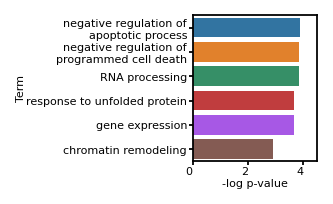

In [109]:
sc.settings.set_figure_params(dpi_save= 400, fontsize=5, facecolor='white', frameon=True, transparent=True, format="pdf")
fig, ax = plt.subplots(figsize=(1.0,1.2))
plt.rc('font', size=5)
plt.margins(x=0, y=0)
ax.tick_params(axis='both', which='major', pad=0.5, size = 2)
ax.set_axisbelow(True)
plt.grid(b=None)
g = sns.barplot(y = "Term", x = "-log p-value", data= GO_results[1:7], ax=ax)
from textwrap import wrap
labels = [x.get_text() for x in ax.get_yticklabels()]
labels = ['\n'.join(wrap(l, 30)) for l in labels]
print(labels)
ax.set_yticklabels(labels, rotation=0, horizontalalignment='right')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, horizontalalignment='right')
ax.set_xlabel("-log p-value", labelpad=0.5)
ax.set_ylabel("Term", labelpad=0.0)
plt.xlim((0,4.5))
# plt.tight_layout()
# plt.savefig("./figures/early_hcg_go.pdf")

In [90]:
dge_results = sc.get.rank_genes_groups_df(granulosa_temp, key="early_hcg_chnages", group = "1hr")
f_tfs = "./../../../../pyscenic_databases/allTFs_mm.txt"   # mouse
tfs = pd.read_csv(f_tfs, header=None)[0].values
dge_results["TFs"] = np.in1d(dge_results.names.values, tfs)
# tf_names = load_tf_names( f_tfs )
# dge_results.to_csv("./../pyobjs/early_hcg_changes.csv")
dge_results

,names,scores,logfoldchanges,pvals,pvals_adj,TFs
0,Gm42418,44.962505,4.626991,0.000000e+00,0.000000e+00,False
1,Hspa8,23.069771,1.049129,9.315434e-118,3.615902e-114,False
2,Cyp19a1,22.580425,1.739384,6.749503e-113,2.095923e-109,False
3,Malat1,21.320866,1.578447,7.270264e-101,1.612597e-97,False
4,Rpl37,20.703678,1.228227,3.209124e-95,6.643528e-92,False
...,...,...,...,...,...,...
31048,Tpt1,-25.740704,-1.073599,4.096525e-146,2.120156e-142,False
31049,Ubb,-25.824312,-1.556267,4.729791e-147,2.937484e-143,False
31050,Rplp0,-26.066961,-1.311272,8.641684e-150,6.708755e-146,False
31051,Rps14,-28.313097,-1.175236,2.384289e-176,2.467977e-172,False


In [94]:
dge_results = dge_results[dge_results["pvals_adj"] < 0.01]
dge_results = dge_results[dge_results["TFs"] == True]
dge_results = dge_results.sort_values(by = "scores", ascending=False)
dge_results.shape

(32, 6)

In [ ]:
# dge_results.to_csv("./../pyobjs/early_hcg_changes_tfs.csv")

In [ ]:
sc.settings.set_figure_params(dpi=300, dpi_save = 300, fontsize=6, facecolor='white', frameon=False, figsize=(2.0, 2.0), vector_friendly = True, transparent=True, format="pdf")
sns.set_style("ticks")
fig, axs = plt.subplots(2,3, figsize = (2.1,1.4))
axs = axs.flatten()
gene_list = dge_results.head(6)["names"]
data = granulosa_temp.obs.join(granulosa.to_df()[gene_list])
for i, gene in enumerate(gene_list):
    print(i, gene)
    sns.boxplot(data, y=gene, x="Sample", ax = axs[i], linewidth=1.0, fliersize=1.0)
#     if i == 0:
#         legend = axs[i].get_legend()
#     axs[i].get_legend().remove()
    axs[i].tick_params(axis='both', which='major', pad=0, size = 2)
    axs[i].set_ylabel(gene, labelpad = 0.0)
    axs[i].set_xlabel("", labelpad = 0.0) 
# plt.legend(ncol=1, prop={'size': 6}, handletextpad=0.5, markerscale = 0.6, title = "Kctd & Inhbb expression",
#            labelspacing = 0.0, frameon = False,  title_fontsize = 7, alignment = "left", 
#            borderpad = 0.1, borderaxespad = 0.1, loc = 6, bbox_to_anchor = (1.0, 0.5))     
plt.subplots_adjust(wspace=0, hspace=0.5)
plt.tight_layout()
plt.savefig("./figures/early_hcg_tfs.pdf", dpi = 300)

In [ ]:
granulosa_mural = sc.read_h5ad("./../../pyobjs_github/granulosa_mural.h5ad")
granulosa_mural.uns['log1p']["base"] = None
granulosa_mural_subset = granulosa_mural[~granulosa_mural.obs["Follicle_type"].isin(["Antral"])]
granulosa_mural_subset = granulosa_mural_subset[~granulosa_mural_subset.obs["Sample"].isin(["Immature"])]
granulosa_mural_subset.shape

In [ ]:
granulosa_mural_subset.obs["timepoint"] = granulosa_mural_subset.obs["Sample"]
celltypes = {'0hr': 0, 
            '1hr': 1, 
            '4hr': 4, 
            '6hr': 6, 
            '8hr': 8,
            '11hr': 11,
            '12hr': 12}
granulosa_mural_subset.obs["timepoint"] = granulosa_mural_subset.obs["timepoint"].map(celltypes)
granulosa_mural_subset.obs["timepoint"] = granulosa_mural_subset.obs["timepoint"].astype(int)

In [ ]:
sc.pp.highly_variable_genes(granulosa_mural_subset, min_disp=0.5, min_mean=0.2)
sc.pl.highly_variable_genes(granulosa_mural_subset)
gene_list = list(granulosa_mural_subset.var_names[granulosa_mural_subset.var.highly_variable])
len(gene_list)

In [ ]:
mural_path = ['GC_Mural-(Antral)']
trend_results = scGAM.compute_gene_trends(granulosa_mural_subset, var_key="timepoint", genes = gene_list, n_bins = 0, use_raw = False, lineages_paths={"mural":mural_path}, group_by = "granulosa_celltypes_reduced")

In [ ]:
trends = trend_results['mural']['trend']

In [ ]:
trends.to_csv("./../pyobjs/mural_granulosa_gene_trends_timepoint_discrete.csv")

In [ ]:
clusters = scGAM.Agglomerative_cluster_gene_trends_from_lineage(trends, n_clusters=5, scale=True)
clusters.value_counts()

In [ ]:
# def plot_gene_expression_trend_clusters(trends, cluster_ids, scale = True):
#     if scale: 
#         trends_df = pd.DataFrame(
#             StandardScaler().fit_transform(trends.T).T,
#             index=trends.index,
#             columns=trends.columns,
#         ).T
#     else:
#         trends_df = trends.T
#     trends_df = trends_df.stack().reset_index().rename(columns = {"level_0": "timepoint", "level_1":"Gene", 0: "Expression"})
#     trends_df["Cluster"] = [cluster_ids[x] for x in trends_df["Gene"]]
#     return trends_df

# def plot_gene_expression_trends(trends, genes, scale = True):
#     if scale: 
#         trends_df = pd.DataFrame(
#             StandardScaler().fit_transform(trends.T).T,
#             index=trends.index,
#             columns=trends.columns,
#         ).T[genes]
#     else:
#         trends_df = trends.T[genes]
#     trends_df = trends_df.stack().reset_index().rename(columns = {"level_0": "timepoint", "level_1":"Gene", 0: "Expression"})
#     return trends_df

In [ ]:
trends_df = plot_gene_expression_trend_clusters(trends = trends, cluster_ids=clusters, scale=True)

In [ ]:
sc.settings.set_figure_params(dpi=200, dpi_save=200, fontsize=6, facecolor='white', frameon=True, figsize=(1.5, 1.5))
fig, ax = plt.subplots(figsize = (2.3,1.5))
plt.grid(False)
sns.set_style("ticks")
plt.margins(x=0, y=0)
ax.tick_params(axis='both', which='major', pad=0.5, size = 2)
g = sns.lineplot(data = trends_df, x = "timepoint", y= "Expression", hue="Cluster", palette="tab10", lw = 1, ax=ax)
g.set_xticks(range(0, 13, 2))
plt.legend(ncol=1, prop={'size': 6}, loc = 2, handletextpad=0.5, markerscale = 0.6, title = "Gene groups", 
           labelspacing = 0.0, frameon = False, title_fontsize = 7, alignment = "left", 
           borderpad = 0.1, borderaxespad = 0.1, bbox_to_anchor = (1.1, 0.75))
ax.get_legend().set_title("Gene groups")
ax.set_xlabel("Time after LH treatment", labelpad=0.5)
ax.set_ylabel("Scaled expression", labelpad=0.0)
plt.tight_layout()

In [ ]:
trends_df = plot_gene_expression_trends(trends = trends, genes=granulosa_mural_subset.var.loc[clusters[clusters == 3].index.values,:].sort_values(by = "dispersions_norm", ascending = False).index.values[0:15], scale=True)

In [ ]:
sc.settings.set_figure_params(dpi=200, fontsize=7, facecolor='white', frameon=True, figsize=(5, 5))
fig, ax = plt.subplots(figsize = (2.5,1.5))
plt.grid(False)
sns.set_style("ticks")
plt.margins(x=0, y=0)
ax.tick_params(axis='both', which='major', pad=0.5, size = 2)
g = sns.lineplot(data = trends_df, x = "timepoint", y= "Expression", hue="Gene", palette="Dark2", lw = 1, ax=ax)
g.set_xticks(range(0, 13, 2))
plt.legend(ncol=1, prop={'size': 6}, loc = 6, handletextpad=0.5, markerscale = 0.6, title = "Gene groups", 
           labelspacing = 0.0, frameon = False, title_fontsize = 6, alignment = "left", 
           borderpad = 0.1, borderaxespad = 0.1, bbox_to_anchor = (1.05, 0.50))
ax.get_legend().set_title("Genes")
ax.set_xlabel("Time after LH treatment", labelpad=0.5)
ax.set_ylabel("Scaled expression", labelpad=0.0)
plt.tight_layout()
# fig.savefig("./figures/increasing_trends.pdf")

In [ ]:
# #Available databases : ‘Human’, ‘Mouse’, ‘Yeast’, ‘Fly’, ‘Fish’, ‘Worm’ 
# gene_set_names = gseapy.get_library_name(organism='Mouse')
# print(gene_set_names)

In [ ]:
# # Some databases of interest:
# GO_Biological_Process_2021
# GO_Biological_Process_2017b
# KEGG_2019_Human
# KEGG_2019_Mouse
# WikiPathways_2019_Human
# WikiPathways_2019_Mouse

In [ ]:
# import gseapy
# enr_res = gseapy.enrichr(gene_list=list(clusters[clusters == 3].index), 
#                      organism='Mouse',
#                      gene_sets=['GO_Biological_Process_2021'],
# #                      description='pathway', 
#                      cutoff = 0.5)

In [ ]:
# GO_results = enr_res.results
# GO_results["-log p-value"] =  -1 * np.log10(GO_results["Adjusted P-value"]) 
# GO_results["Term"] = [x.split(" (")[0] for x in GO_results["Term"]]
# GO_results[0:5]

In [ ]:
# sc.settings.set_figure_params(dpi_save= 400, fontsize=5, facecolor='white', frameon=True, transparent=True, format="pdf")
# fig, ax = plt.subplots(figsize=(0.9,1.5))
# plt.rc('font', size=5)
# plt.margins(x=0, y=0)
# ax.tick_params(axis='both', which='major', pad=0.5, size = 2)
# ax.set_axisbelow(True)
# plt.grid(b=None)
# g = sns.barplot(y = "Term", x = "-log p-value", data= GO_results[0:10], ax=ax)
# # from textwrap import wrap
# # labels = [x.get_text() for x in ax.get_yticklabels()]
# # labels = ['\n'.join(wrap(l, 40)) for l in labels]
# # # print(labels)
# # ax.set_yticklabels(labels, rotation=0, horizontalalignment='right')
# ax.set_xticklabels(ax.get_xticklabels(), rotation=0, horizontalalignment='right')
# ax.set_xlabel("-log p-value", labelpad=0.5)
# ax.set_ylabel("Term", labelpad=0.0)
# plt.tight_layout()

In [ ]:
granulosa_mural_bulk = sc.read_h5ad("./../../pyobjs_github/granulosa_mural_bulk_raw_counts.h5ad")
# granulosa_mural_bulk.uns['log1p']["base"] = None
granulosa_mural_bulk

In [ ]:
granulosa_mural_bulk[granulosa_mural_bulk.obs["Sample"] == "12hr"].obs["Follicle_type"].value_counts()

In [ ]:
sc.pp.normalize_total(granulosa_mural_bulk, target_sum=1e4)
sc.pp.log1p(granulosa_mural_bulk)

In [ ]:
granulosa_mural_bulk_subset = granulosa_mural_bulk[~granulosa_mural_bulk.obs["Sample"].isin(["Immature"])]
granulosa_mural_bulk_subset.shape

In [ ]:
granulosa_mural_bulk_subset.obs["Follicle_type"].value_counts()

In [ ]:
granulosa_mural_bulk_subset = granulosa_mural_bulk_subset[granulosa_mural_bulk_subset.obs["Follicle_type"].isin(["Antral"])]
granulosa_mural_bulk_subset.shape

In [ ]:
sc.pp.highly_variable_genes(granulosa_mural_bulk_subset, min_disp=0.5, min_mean=0.5)
sc.pl.highly_variable_genes(granulosa_mural_bulk_subset)
gene_list = list(granulosa_mural_bulk_subset.var_names[granulosa_mural_bulk_subset.var.highly_variable])
len(gene_list)

In [ ]:
"Edn2" in gene_list

In [ ]:
granulosa_mural_bulk_subset.obs["timepoint"] = granulosa_mural_bulk_subset.obs["Sample"]
celltypes = {'Immature': -1, 
             '0hr': 0, 
            '1hr': 1, 
            '4hr': 4, 
            '6hr': 6, 
            '8hr': 8,
            '11hr': 11,
            '12hr': 12}
granulosa_mural_bulk_subset.obs["timepoint"] = granulosa_mural_bulk_subset.obs["timepoint"].map(celltypes)
granulosa_mural_bulk_subset.obs["timepoint"] = granulosa_mural_bulk_subset.obs["timepoint"].astype(np.int_)

In [ ]:
antral_mural_path = ['Antral']
trend_results = scGAM.compute_gene_trends(granulosa_mural_bulk_subset, var_key="timepoint", genes = gene_list, n_bins = 0, use_raw = False, lineages_paths={"Antral": antral_mural_path}, group_by = "Follicle_type")

In [ ]:
trends = trend_results['Antral']['trend']
trends.shape

In [ ]:
trends.to_csv("./../pyobjs/follicle_muralgranulosa_gene_trends_timepoint_discrete.csv")

In [ ]:
trends= pd.read_csv("./../pyobjs/follicle_muralgranulosa_gene_trends_timepoint_discrete.csv", index_col=0)
trends

In [ ]:
clusters = scGAM.Agglomerative_cluster_gene_trends_from_lineage(trends, n_clusters=6, scale=True)
clusters.value_counts()

In [ ]:
trends_df = plot_gene_expression_trend_clusters(trends = trends, cluster_ids=clusters, scale=True)

In [ ]:
sc.settings.set_figure_params(dpi=200, dpi_save=200, fontsize=6, facecolor='white', frameon=True, figsize=(1.5, 1.5))
fig, ax = plt.subplots(figsize = (2.3,1.5))
plt.grid(False)
sns.set_style("ticks")
plt.margins(x=0, y=0)
ax.tick_params(axis='both', which='major', pad=0.5, size = 2)
g = sns.lineplot(data = trends_df, x = "timepoint", y= "Expression", hue="Cluster", palette="tab10", lw = 1, ax=ax)
g.set_xticks([0,2,4,6])
plt.legend(ncol=1, prop={'size': 6}, loc = 2, handletextpad=0.5, markerscale = 0.6, title = "Gene groups", 
           labelspacing = 0.0, frameon = False, title_fontsize = 6, alignment = "left", 
           borderpad = 0.1, borderaxespad = 0.1, bbox_to_anchor = (1.05, 0.75))
ax.get_legend().set_title("Gene groups")
ax.set_xlabel("Time after hCG treatment", labelpad=0.5)
ax.set_ylabel("Scaled expression", labelpad=0.0)
plt.tight_layout()
fig.savefig("./figures/mural _granulosa_gene_group_trends.pdf")
# plt.show()

In [ ]:
trends_df = plot_gene_expression_trends(trends = trends, genes=granulosa_mural_bulk_subset.var.loc[clusters[clusters == 0].index.values,:].sort_values(by = "dispersions_norm", ascending = False).index.values[0:10], scale=True)

In [ ]:
sc.settings.set_figure_params(dpi=200, fontsize=6, facecolor='white', frameon=True, figsize=(5, 5))
fig, ax = plt.subplots(figsize = (2.3,1.5))
plt.grid(False)
sns.set_style("ticks")
plt.margins(x=0, y=0)
ax.tick_params(axis='both', which='major', pad=0.5, size = 2)
g = sns.lineplot(data = trends_df, x = "timepoint", y= "Expression", hue="Gene", palette="Dark2", lw = 1, ax=ax)
g.set_xticks([0,2,4,6])
plt.legend(ncol=1, prop={'size': 6}, loc = 6, handletextpad=0.5, markerscale = 0.6, title = "Gene groups", 
           labelspacing = 0.0, frameon = False, title_fontsize = 6, alignment = "left", 
           borderpad = 0.1, borderaxespad = 0.1, bbox_to_anchor = (1.05, 0.50))
ax.get_legend().set_title("Genes")
ax.set_xlabel("Time after hCG treatment", labelpad=0.5)
ax.set_ylabel("Scaled expression", labelpad=0.0)
plt.tight_layout()
fig.savefig("./figures/decreasing_trends.pdf")

In [ ]:
import gseapy
enr_res = gseapy.enrichr(gene_list=list(clusters[clusters == 0].index), 
                     organism='Mouse',
                     gene_sets=['GO_Biological_Process_2021'],
#                      description='pathway', 
                     cutoff = 0.01)

In [ ]:
GO_results = enr_res.results
GO_results["-log p-value"] =  -1 * np.log10(GO_results["Adjusted P-value"]) 
GO_results["Term"] = [x.split(" (")[0] for x in GO_results["Term"]]
GO_results[0:10]

In [ ]:
GO_results[GO_results["Term"] == "negative regulation of apoptotic process"]

In [ ]:
apoptosis_genes = GO_results[GO_results["Term"] == "negative regulation of apoptotic process"].Genes.values[0].split(";")
from gseapy import Biomart
bm = Biomart()
h2m = bm.query(dataset='hsapiens_gene_ensembl',
               attributes=['external_gene_name',
                           'mmusculus_homolog_associated_gene_name'])
h2m.index = h2m["external_gene_name"]
apoptosis_genes = h2m.loc[apoptosis_genes]["mmusculus_homolog_associated_gene_name"]
apoptosis_genes = apoptosis_genes[~pd.isna(apoptosis_genes)]

In [ ]:
apoptosis_genes

In [ ]:
apoptosis_genes.to_csv("./../pyobjs/apoptosis_genes.csv")

In [ ]:
sc.settings.set_figure_params(dpi_save= 400, fontsize=5, facecolor='white', frameon=True, transparent=True, format="pdf")
fig, ax = plt.subplots(figsize=(1.2,1.5))
plt.rc('font', size=6)
plt.margins(x=0, y=0)
ax.tick_params(axis='both', which='major', pad=0.5, size = 2)
ax.set_axisbelow(True)
plt.grid(b=None)
g = sns.barplot(y = "Term", x = "-log p-value", data= GO_results[0:15], ax=ax)
# from textwrap import wrap
# labels = [x.get_text() for x in ax.get_yticklabels()]
# labels = ['\n'.join(wrap(l, 40)) for l in labels]
# print(labels)
# ax.set_yticklabels(labels, rotation=0, horizontalalignment='right')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, horizontalalignment='right')
ax.set_xlabel("-log p-value", labelpad=0.5)
ax.set_ylabel("Term", labelpad=0.0)
# plt.tight_layout()
plt.savefig("./figures/decreasing_trends_go.pdf")

In [ ]:
trends_df = plot_gene_expression_trends(trends = trends, genes=granulosa_mural_bulk_subset.var.loc[clusters[clusters == 2].index.values,:].sort_values(by = "dispersions_norm", ascending = False).index.values[0:10], scale=True)

In [ ]:
sc.settings.set_figure_params(dpi=200, fontsize=6, facecolor='white', frameon=True, figsize=(5, 5))
fig, ax = plt.subplots(figsize = (2.3,1.5))
plt.grid(False)
sns.set_style("ticks")
plt.margins(x=0, y=0)
ax.tick_params(axis='both', which='major', pad=0.5, size = 2)
g = sns.lineplot(data = trends_df, x = "timepoint", y= "Expression", hue="Gene", palette="Dark2", lw = 1, ax=ax)
g.set_xticks([0,2,4,6])
plt.legend(ncol=1, prop={'size': 6}, loc = 6, handletextpad=0.5, markerscale = 0.6, title = "Gene groups", 
           labelspacing = 0.0, frameon = False, title_fontsize = 6, alignment = "left", 
           borderpad = 0.1, borderaxespad = 0.1, bbox_to_anchor = (1.05, 0.50))
ax.get_legend().set_title("Genes")
ax.set_xlabel("Time after hCG treatment", labelpad=0.5)
ax.set_ylabel("Scaled expression", labelpad=0.0)
plt.tight_layout()
fig.savefig("./figures/increasing_trends.pdf")

In [ ]:
import gseapy
enr_res = gseapy.enrichr(gene_list=list(granulosa_mural_bulk_subset.var.loc[clusters[clusters == 2].index.values,:].sort_values(by = "dispersions_norm", ascending = False).index.values), 
                     organism='Mouse',
                     gene_sets=['GO_Biological_Process_2021'],
#                      description='pathway', 
                     cutoff = 0.01)

In [ ]:
GO_results = enr_res.results
GO_results["-log p-value"] =  -1 * np.log10(GO_results["Adjusted P-value"]) 
GO_results["Term"] = [x.split(" (")[0] for x in GO_results["Term"]]
GO_results[0:15]

In [ ]:
sc.settings.set_figure_params(dpi_save= 400, fontsize=5, facecolor='white', frameon=True, transparent=True, format="pdf")
fig, ax = plt.subplots(figsize=(1.2,1.5))
plt.rc('font', size=6)
plt.margins(x=0, y=0)
ax.tick_params(axis='both', which='major', pad=0.5, size = 2)
ax.set_axisbelow(True)
plt.grid(b=None)
g = sns.barplot(y = "Term", x = "-log p-value", data= GO_results[0:15], ax=ax)
# from textwrap import wrap
# labels = [x.get_text() for x in ax.get_yticklabels()]
# labels = ['\n'.join(wrap(l, 40)) for l in labels]
# print(labels)
# ax.set_yticklabels(labels, rotation=0, horizontalalignment='right')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, horizontalalignment='right')
ax.set_xlabel("-log p-value", labelpad=0.5)
ax.set_ylabel("Term", labelpad=0.0)
# plt.tight_layout()
plt.savefig("./figures/increasing_trends_go.pdf")

In [ ]:
trends_df = plot_gene_expression_trends(trends = trends, genes=granulosa_mural_bulk_subset.var.loc[clusters[clusters == 3].index.values,:].sort_values(by = "dispersions_norm", ascending = False).index.values[0:10], scale=True)

In [ ]:
sc.settings.set_figure_params(dpi=200, fontsize=7, facecolor='white', frameon=True, figsize=(5, 5))
fig, ax = plt.subplots(figsize = (2.3,1.5))
plt.grid(False)
sns.set_style("ticks")
plt.margins(x=0, y=0)
ax.tick_params(axis='both', which='major', pad=0.5, size = 2)
g = sns.lineplot(data = trends_df, x = "timepoint", y= "Expression", hue="Gene", palette="Dark2", lw = 1, ax=ax)
g.set_xticks([0,2,4,6])
plt.legend(ncol=1, prop={'size': 6}, loc = 6, handletextpad=0.5, markerscale = 0.6, title = "Gene groups", 
           labelspacing = 0.0, frameon = False, title_fontsize = 7, alignment = "left", 
           borderpad = 0.1, borderaxespad = 0.1, bbox_to_anchor = (1.05, 0.50))
ax.get_legend().set_title("Genes")
ax.set_xlabel("Time after LH treatment", labelpad=0.5)
ax.set_ylabel("Scaled expression", labelpad=0.0)
plt.tight_layout()
# fig.savefig("./figures/granulosa_late_increasing_trends.pdf")

In [ ]:
import gseapy
enr_res = gseapy.enrichr(gene_list=list(granulosa_mural_bulk_subset.var.loc[clusters[(clusters == 3) | (clusters == 3)].index.values,:].sort_values(by = "dispersions_norm", ascending = False).index.values), 
                     organism='Mouse',
                     gene_sets=['GO_Biological_Process_2021'],
#                      description='pathway', 
                     cutoff = 0.01)

In [ ]:
GO_results = enr_res.results
GO_results["-log p-value"] =  -1 * np.log10(GO_results["Adjusted P-value"]) 
GO_results["Term"] = [x.split(" (")[0] for x in GO_results["Term"]]
GO_results[0:15]

In [ ]:
freq_table = granulosa_mural_subset.obs.groupby(['FollicleNumber', "Sample", "phase"]).size().reset_index(name='count')
freq_table['total_count'] = freq_table.groupby(['FollicleNumber', "Sample"])['count'].transform('sum')
freq_table['proportion'] = freq_table['count'] / freq_table['total_count']
freq_table = freq_table[freq_table["count"] > 0]
freq_table.head(20)

In [ ]:
sc.settings.set_figure_params(dpi=80, fontsize=6, facecolor='white', frameon=False, figsize=(2.0, 2.0), vector_friendly = False, transparent=True, format="pdf")
sns.set_style("ticks")
fig, ax = plt.subplots(figsize = (2.8,1.5))
plt.margins(x=0, y=0)
ax.tick_params(axis='both', which='major', pad=0, size = 2)
sns.barplot(freq_table, x = "Sample", y = "proportion", dodge=True, hue="phase", palette="Set2", ax=ax)
plt.legend(ncol=1, prop={'size': 6}, handletextpad=0.5, markerscale = 0.6, title = "Cell cycle",
           labelspacing = 0.0, frameon = False,  title_fontsize = 7, alignment = "left", 
           borderpad = 0.1, borderaxespad = 0.1, loc = 1, bbox_to_anchor = (1.0, 1.0))
plt.rcParams['legend.title_fontsize'] = 9
ax.set_ylim(0,1.0)
ax.set_ylabel("Follicle type", labelpad = 0)
ax.set_xlabel("Cell proportions", labelpad = 1.0)
plt.tight_layout()
plt.savefig("./figures/cellcycle_all_granulosa_mural.pdf")

In [ ]:
adata_magic = pd.read_csv("./../../../pyobjs/adata_ovary_combined_magic_edn2_subset.csv", index_col=0)
adata_magic.index = [x.replace("4hr_replicate", "4hr") for x in adata_magic.index]
dremi_df = pd.read_csv("./../../../pyobjs/dremi_magic_Edn2.csv", index_col=0)

In [ ]:
print(dremi_df.loc["Edn2",])
dremi_df = dremi_df[dremi_df["means"] > 0.1]
dremi_df = dremi_df[dremi_df["dispersions"] > 0.1]

In [ ]:
adata_magic.shape

In [ ]:
adata_magic["Sample"] = adata_ovary_combined.obs["Sample"]

In [ ]:
sc.settings.set_figure_params(dpi=80, dpi_save = 300, fontsize=6, facecolor='white', frameon=False, figsize=(1.0, 1.0), vector_friendly = True, transparent=True, format="pdf")
sns.set_style("ticks")
fig, axs = plt.subplots(2,2, figsize = (1.8,1.5))
axs = axs.flatten()
x_gene = "Edn2"
y_gene_list = dremi_df["gene"][1:5]
for i, y_gene in enumerate(y_gene_list):
    print(i, y_gene)
    sns.scatterplot(adata_magic.loc[adata_ovary_combined.obs_names], x="Edn2", y = y_gene, hue = "Sample", palette="Set2", ax=axs[i], 
                    s = 0.5, alpha = 0.5, linewidths = 0.0)
    if i == 0:
        handles, labels = axs[i].get_legend_handles_labels()
        legend = axs[i].get_legend()
    axs[i].get_legend().remove()
    axs[i].tick_params(axis='both', which='major', pad=0, size = 2)
    axs[i].set_ylabel(y_gene, labelpad = 0.0, fontstyle = "italic")
    axs[i].set_xlabel(x_gene, labelpad = 0.0, fontstyle = "italic")
    
fig.legend(handles, labels, ncol=1, prop={'size': 6}, handletextpad=0.5, markerscale = 0.6, title = "Sample",
           labelspacing = 0.0, frameon = False,  title_fontsize = 7, alignment = "left", 
           borderpad = 0.1, borderaxespad = 0.1, loc = 6, bbox_to_anchor = (1.0, 0.5))     
# fig.delaxes(axs[0])
plt.margins(x=0, y=0)
plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
plt.savefig("./figures/edn2_dremi_coor.png", dpi = 300)

In [ ]:
ovary_11hr = sc.read_h5ad("./../pyobjs/11hr_ovary.h5ad")
ovary_12hr = sc.read_h5ad("./../pyobjs/12hr_ovary.h5ad")

In [ ]:
sc.settings.set_figure_params(dpi=200, dpi_save= 300, fontsize=8, facecolor='white', frameon=False, figsize=(2.0,2.0), vector_friendly = True, transparent=True, format="pdf")
sc.pl.spatial(ovary_12hr, color=["granulosa_clusters"], spot_size=30, ncols=3, wspace=0.1)

In [ ]:
sample = "12hr"
celltypes = {'0': "GC_Mural-(Antral)", 
             '1': "GC_Lytic-1", 
            '2': "GC_Lytic-2", 
            '3': "GC_Mural-(Antral)", 
            '4': "GC_Mural-(Antral)", 
            '5': "GC_Mural-(Atretic)", 
            '6': pd.NA,
            '7': "GC_Mural-(Preantral)", 
            '8': "GC_Cumulus"}
ovary_12hr.obs["granulosa_celltypes"] = ovary_12hr.obs["granulosa_clusters"].map(celltypes).astype("category")

In [ ]:
from pylab import *
cmap = cm.get_cmap('tab20')
palette_custom = [matplotlib.colors.rgb2hex(cmap(i)) for i in range(cmap.N)]
cmap
sc.settings.set_figure_params(dpi=200, dpi_save=300, facecolor='white', fontsize=6, frameon=True, figsize=(3, 3), format="pdf")
sc.pl.spatial(ovary_12hr, color=["granulosa_celltypes"], spot_size=30, frameon=False, wspace=0.3, na_in_legend=False, title="Granulosa celltypes", save="granulosa_celltypes_12hr")

In [ ]:
sc.settings.set_figure_params(dpi=200, dpi_save=300, facecolor='white', fontsize=6, frameon=True, figsize=(0.8,0.8), format="pdf")
fig, axs = plt.subplots(2,2, figsize = (2.3,1.8))
axs = axs.flatten()
for i, gene in enumerate(["Edn2", "Ptgs1", "Junb", "Adamts1"]):
    sc.pl.spatial(adata_ovary_combined[adata_ovary_combined.obs["Sample"] == "12hr"], color=gene, spot_size=30, frameon=False, wspace=0.1, ncols=5, cmap=sns.blend_palette(["lightgrey", sns.xkcd_rgb["black"]], as_cmap=True), ax=axs[i], vmax = "p99.2", show=False)
    axs[i].set_title(axs[i].get_title(), pad=0)
for i in range(1,5):
    mappable = fig.axes[-i].collections[1]
    colorBar = fig.axes[-i]
    colorBar.remove()
    plt.colorbar(mappable=mappable, ax=axs[-i],
                 fraction=0.25, aspect=7, location = "right",
                 pad=0 ,shrink = 0.3)
for i in range(1,5):
    fig.axes[-i].tick_params(length = 2, pad = 0.0)
    
plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
# plt.show()
plt.savefig("./figures/rupture_asscoiated.pdf")

In [ ]:
sc.settings.set_figure_params(dpi=200, dpi_save=300, facecolor='white', fontsize=6, frameon=True, figsize=(0.8,0.8), format="pdf")
fig, axs = plt.subplots(1, 3, figsize = (3.0,1.0))
axs = axs.flatten()
for i, gene in enumerate(["Sfrp4", "Gm2a", "Ltbp1"]):
    sc.pl.spatial(adata_ovary_combined[adata_ovary_combined.obs["Sample"] == "12hr"], color=gene, spot_size=30, frameon=False, wspace=0.1, ncols=5, cmap=sns.blend_palette(["lightgrey", sns.xkcd_rgb["black"]], as_cmap=True), ax=axs[i], vmin = "p1.0", vmax = "p99.2", show=False)
    axs[i].set_title(axs[i].get_title(), pad=0)
for i in range(1,4):
    mappable = fig.axes[-i].collections[1]
    colorBar = fig.axes[-i]
    colorBar.remove()
    plt.colorbar(mappable=mappable, ax=axs[-i],
                 fraction=0.25, aspect=7, location = "right",
                 pad=0 ,shrink = 0.3)
for i in range(1,4):
    fig.axes[-i].tick_params(length = 2, pad = 0.0)
    
plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
# plt.show()
plt.savefig("./figures/12hr_lytic_asscoiated.pdf")

In [ ]:
sc.settings.set_figure_params(dpi=200, dpi_save=300, facecolor='white', fontsize=6, frameon=True, figsize=(0.8,0.8), format="pdf")
fig, axs = plt.subplots(1, 3, figsize = (3.0,1.0))
axs = axs.flatten()
for i, gene in enumerate(["Rhox8", "Star", "Ctsl"]):
    sc.pl.spatial(adata_ovary_combined[adata_ovary_combined.obs["Sample"] == "12hr"], color=gene, spot_size=30, frameon=False, wspace=0.1, ncols=5, cmap=sns.blend_palette(["lightgrey", sns.xkcd_rgb["black"]], as_cmap=True), ax=axs[i], vmin = "p1.0", vmax = "p99.2", show=False)
    axs[i].set_title(axs[i].get_title(), pad=0)
for i in range(1,4):
    mappable = fig.axes[-i].collections[1]
    colorBar = fig.axes[-i]
    colorBar.remove()
    plt.colorbar(mappable=mappable, ax=axs[-i],
                 fraction=0.25, aspect=7, location = "right",
                 pad=0 ,shrink = 0.3)
for i in range(1,4):
    fig.axes[-i].tick_params(length = 2, pad = 0.0)
    
plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
# plt.show()
plt.savefig("./figures/12hr_antral_asscoiated.pdf")

In [ ]:
sc.tl.rank_genes_groups(ovary_12hr, groupby="granulosa_celltypes", groups=["GC_Lytic-1"], reference = "GC_Lytic-2", method="wilcoxon", key_added="between_lytic_diff")
sc.tl.rank_genes_groups(ovary_12hr, groupby="granulosa_celltypes", groups=["GC_Lytic-1"], reference = "GC_Mural-(Antral)", method="wilcoxon", key_added="between_lytic_and_mural_diff")

In [ ]:
result = ovary_12hr.uns['between_lytic_diff']
groups = result['names'].dtype.names
dge_results = pd.DataFrame(
    {key: result[key][group]
    for group in groups for key in ['names', "logfoldchanges", "pvals_adj"]})
print(dge_results)

In [ ]:
sc.settings.set_figure_params(dpi=200, dpi_save=300, facecolor='white', fontsize=6, frameon=False, figsize=(2, 2), format="pdf")
sc.pl.spatial(ovary_12hr, color=dge_results.head(10)["names"], spot_size=30, cmap="viridis", ncols=5, wspace = 0.0)

In [ ]:
sc.settings.set_figure_params(dpi=200, dpi_save=300, facecolor='white', fontsize=6, frameon=False, figsize=(2, 2), format="pdf")
sc.pl.spatial(ovary_12hr, color=dge_results.tail(10)["names"], spot_size=30, cmap="viridis", ncols=5, wspace = 0.0)

In [ ]:
result = ovary_12hr.uns['between_lytic_and_mural_diff']
groups = result['names'].dtype.names
dge_results = pd.DataFrame(
    {key: result[key][group]
    for group in groups for key in ['names', "logfoldchanges", "pvals_adj"]})
print(dge_results)

In [ ]:
sc.settings.set_figure_params(dpi=200, dpi_save=300, facecolor='white', fontsize=6, frameon=False, figsize=(2, 2), format="pdf")
sc.pl.spatial(ovary_12hr, color=dge_results.head(10)["names"], spot_size=30, cmap="viridis", ncols=5, wspace = 0.0)

In [ ]:
sc.settings.set_figure_params(dpi=200, dpi_save=300, facecolor='white', fontsize=6, frameon=False, figsize=(2, 2), format="pdf")
sc.pl.spatial(ovary_12hr, color=dge_results.tail(10)["names"], spot_size=30, cmap="viridis", ncols=5, wspace = 0.0)

In [ ]:
sc.settings.set_figure_params(dpi=200, dpi_save=300, facecolor='white', fontsize=6, frameon=False, figsize=(2, 2), format="pdf")
sc.pl.spatial(ovary_12hr, color=["Edn2", "Adamts1", "Ldhd", "Apln", "Akr1c18"], spot_size=30, cmap="viridis", ncols=5, wspace = 0.0)

In [ ]:
sc.settings.set_figure_params(dpi=200, dpi_save=300, facecolor='white', fontsize=6, frameon=False, figsize=(2, 2), format="pdf")
sc.pl.spatial(ovary_11hr, color=["Edn2", "Adamts1", "Ldhd", "Akr1c18"], spot_size=30, cmap="viridis", ncols=5, wspace = 0.0)